# **Advanced Portfolio Optimization with LSTMs**

**Overview:**

Portfolio optimization in finance is the act of optimizing the best portfolio of investments to maximize returns with a given risk. This has been heavily studied through **Modern Portfolio Theory**, which was developed by American Economist **Harry Markowitz**. Currently one of the most common methods of portfolio optimization is **Mean Variance Optimization**, which basically means optimizing the portfolio based on the mean of the variance (also known as risk).


**Objective:**

The goal of this project is to combine the use of MVO along with **Deep Learning** Models in order to achieve the process of portfolio optimization. In order to do this, I will be using Long Short Term Memory or **LSTM** models to predict future returns on assets. Then I will pick the best performing assets based off of moving averages for the predicted returns, and use MVO to find the optimal performing portfolio of those assets that maximizes the **Sharpe Ratio**.




## **Installing Packages**

In [1]:
!pip install yfinance
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sn
import yfinance as yf
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Analysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## **Loading Data**

We will load in data from 10 assets for our original portfolio. Our dataset will be the daily closing prices from those assets from the past 5 years. The data is loaded in and visualized below:

In [3]:
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "NVDA", "GOOG", "SPY", "XLK", "QQQ", "GLD"]

data = yf.download(tickers, start="2020-01-05", end="2025-01-05")

prices = data["Close"].dropna(how="all")

prices

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GLD,GOOG,MSFT,NVDA,QQQ,SPY,TSLA,XLK
Date,,,,,,,,,,
2020-01-06,72.662704,95.143997,147.389999,69.460922,152.109894,5.901757,209.056122,300.054535,30.102667,88.457848
2020-01-07,72.320976,95.343002,147.970001,69.417580,150.722977,5.973208,209.027100,299.210876,31.270666,88.419609
2020-01-08,73.484337,94.598503,146.860001,69.964615,153.123749,5.984411,210.598221,300.805573,32.809334,89.365738
2020-01-09,75.045235,95.052498,146.029999,70.737328,155.036743,6.050136,212.382690,302.845184,32.089333,90.378761
2020-01-10,75.214874,94.157997,146.910004,71.230568,154.319351,6.082501,211.839569,301.973724,31.876667,90.168510
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,255.589996,223.750000,241.399994,194.039993,430.529999,137.009995,522.559998,595.010010,431.660004,237.490005
2024-12-30,252.199997,221.300003,240.630005,192.690002,424.829987,137.490005,515.609985,588.219971,417.410004,234.470001
2024-12-31,250.419998,219.389999,242.130005,190.440002,421.500000,134.289993,511.230011,586.080017,403.839996,232.520004


<Axes: xlabel='Date'>

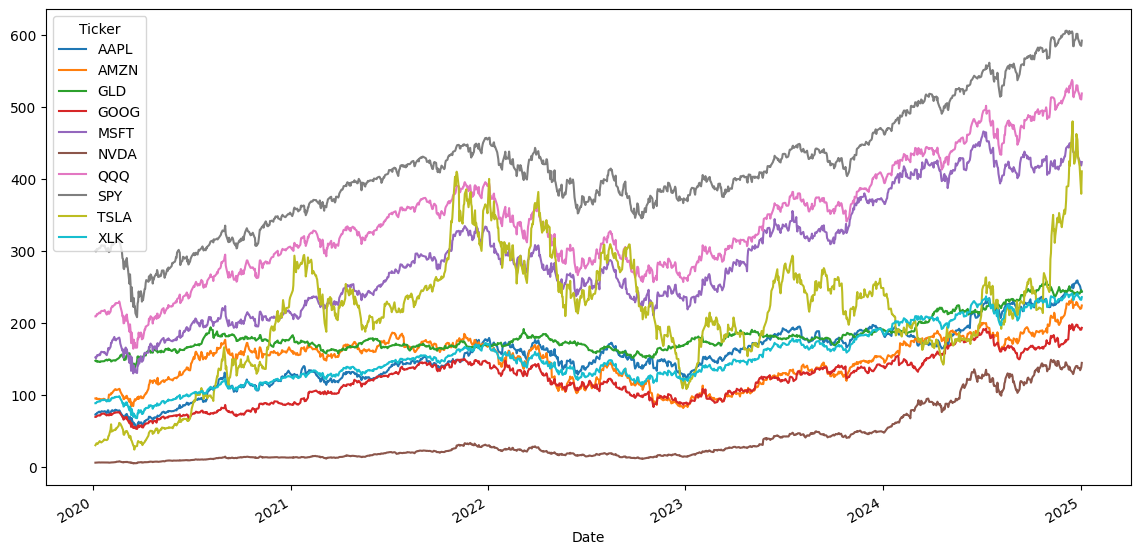

In [4]:
prices.plot(figsize=(14, 7))

## **Exploratory Data Analysis**

**Daily returns per asset:**

In [5]:
returns = ((prices / prices.shift(1)) - 1)
returns

Ticker,AAPL,AMZN,GLD,GOOG,MSFT,NVDA,QQQ,SPY,TSLA,XLK
Date,,,,,,,,,,
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,-0.004703,0.002092,0.003935,-0.000624,-0.009118,0.012107,-0.000139,-0.002812,0.038801,-0.000432
2020-01-08,0.016086,-0.007809,-0.007502,0.007880,0.015928,0.001876,0.007516,0.005330,0.049205,0.010700
2020-01-09,0.021241,0.004799,-0.005652,0.011044,0.012493,0.010983,0.008473,0.006780,-0.021945,0.011336
2020-01-10,0.002260,-0.009411,0.006026,0.006973,-0.004627,0.005350,-0.002557,-0.002878,-0.006627,-0.002326
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,-0.013242,-0.014534,-0.006871,-0.015525,-0.017302,-0.020868,-0.013293,-0.010527,-0.049479,-0.013295
2024-12-30,-0.013263,-0.010950,-0.003190,-0.006957,-0.013240,0.003503,-0.013300,-0.011412,-0.033012,-0.012716
2024-12-31,-0.007058,-0.008631,0.006234,-0.011677,-0.007838,-0.023275,-0.008495,-0.003638,-0.032510,-0.008317


**Expected Annual Returns:**

In [6]:
annual_returns = returns.mean() * 251 * 100
annual_returns.values.sort()
annual_returns

,0
Ticker,
AAPL,11.227119
AMZN,15.777743
GLD,21.435730
GOOG,23.481212
MSFT,23.554187
NVDA,25.080548
QQQ,25.648077
SPY,29.141983
TSLA,74.684895


**Annual Returns by Asset:**

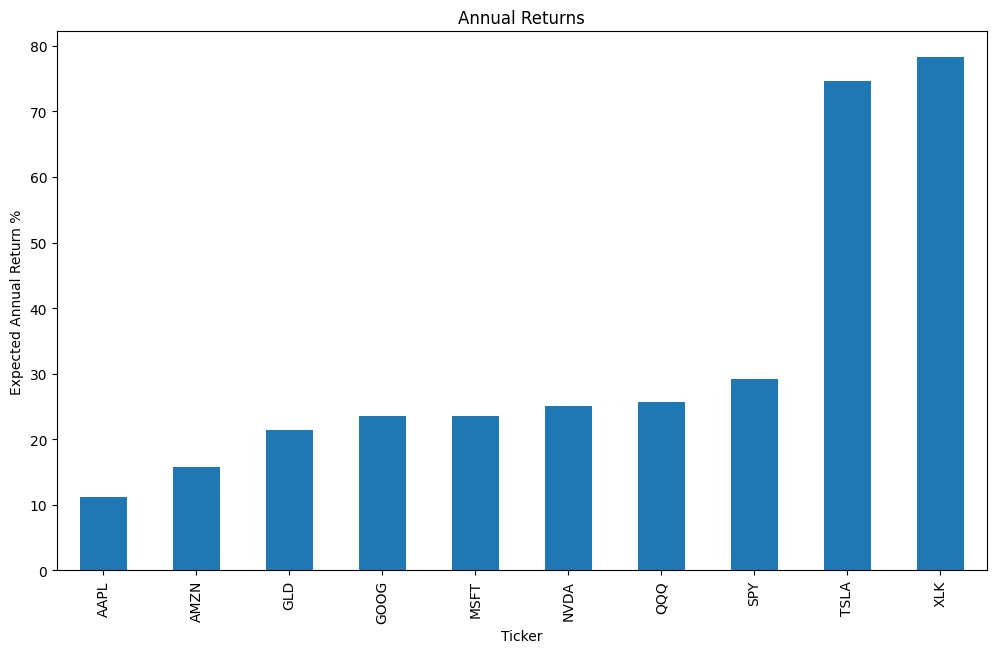

In [7]:
annual_returns.plot(kind="bar", figsize=(12, 7))
plt.title("Annual Returns")
plt.ylabel("Expected Annual Return %")
plt.show()

In [8]:
num_assets = len(tickers)
num_assets

10

In [9]:
weights = np.random.random(num_assets)
weights /= np.sum(weights)
weights

array([0.09493499, 0.15951967, 0.11500167, 0.03747835, 0.18397809,
       0.05738307, 0.10662417, 0.05253777, 0.13362277, 0.05891944])

**Mean Annual Returns (with random weights):**

In [10]:
mean_annual_returns = np.sum(annual_returns * weights)
mean_annual_returns

31.55780146708108

Annual Volatility:

In [11]:
np.sqrt(np.dot(weights.T,np.dot(returns.cov() * 251, weights))) * 100

27.416889767146113

**Correlation Matrix:**

<Axes: xlabel='Ticker', ylabel='Ticker'>

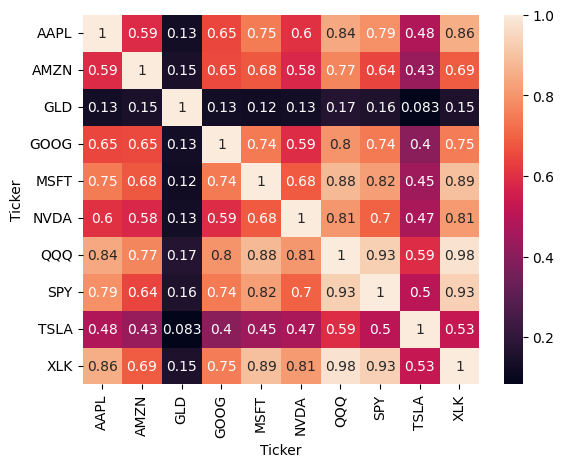

In [12]:
corr_matrix = returns.corr()
sn.heatmap(corr_matrix, annot=True)

**Two Highly Correlated Assets:**

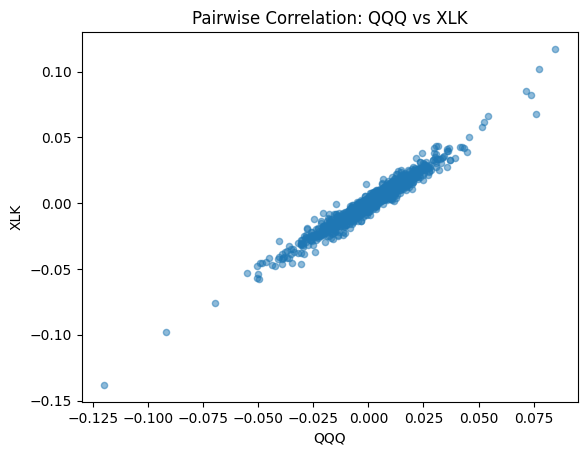

In [13]:
returns[["QQQ", "XLK"]].plot.scatter(x="QQQ", y="XLK", alpha=0.5)
plt.title("Pairwise Correlation: QQQ vs XLK")
plt.show()

**Two Stocks With Little Correlation:**

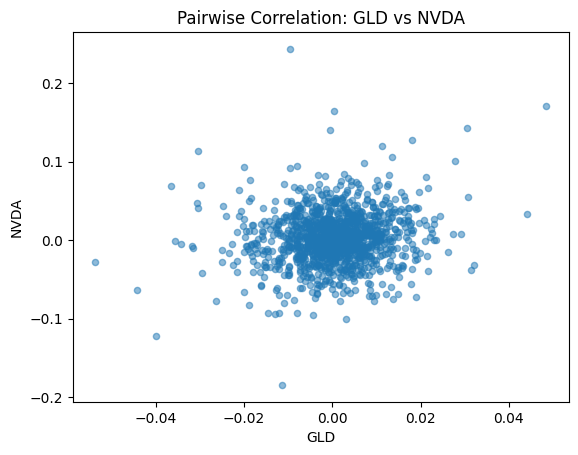

In [14]:
returns[["GLD", "NVDA"]].plot.scatter(x="GLD", y="NVDA", alpha=0.5)
plt.title("Pairwise Correlation: GLD vs NVDA")
plt.show()

## **Feature Engineering and Model Training**

In [15]:
def Scale_data_set(data):

  dataset = data.values
  # Get the number of rows to train the model on
  training_data_len = int(np.ceil( len(dataset) * .8 ))

  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)
  return training_data_len, scaled_data, dataset, scaler

In [16]:
def Creating_training_data(training_data_len, scaled_data):
  # Create the training data set
  # Create the scaled training data set
  train_data = scaled_data[0:int(training_data_len), :]
  # Split the data into x_train and y_train data sets
  x_train = []
  y_train = []

  for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])


  # Convert the x_train and y_train to numpy arrays
  x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshape the data
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  # x_train.shape

  return x_train, y_train

In [17]:
def LSTM_model(x_train, y_train, look_back):

  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))  # Output layer for asset returns

  # Compile the model
  model.compile(optimizer='adam', loss='mse')

  # Train the model
  model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

  return model

In [18]:
def train_and_validate(model, training_data_len, scaled_data, dataset, scaler):
  # Create the testing data set
  test_data = scaled_data[training_data_len - 60: , :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(60, len(test_data)):
      x_test.append(test_data[i-60:i, 0])

  # Convert the data to a numpy array
  x_test = np.array(x_test)

  # Reshape the data
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

  # Get the models predicted price values
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)

  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  mae = mean_absolute_error(y_test, predictions)
  mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

  return predictions, rmse, mae, mape, y_test

In [19]:
def Stock_prediction(data, title):
  training_data_len, scaled_data, dataset, scaler = Scale_data_set(data)
  x_train, y_train = Creating_training_data(training_data_len, scaled_data)
  model = LSTM_model(x_train, y_train, 60)
  predictions, rmse, mae, mape, y_test = train_and_validate(model, training_data_len, scaled_data, dataset, scaler)

  return rmse, predictions, mae, mape, y_test

In [20]:
# Visualize Model Predictions
def visualize_predictions(predictions, y_test, stock_symbol):
    plt.figure(figsize=(14,7))
    plt.plot(y_test, label=f'{stock_symbol} Actual Prices')
    plt.plot(predictions, label=f'{stock_symbol} Predicted Prices')
    plt.legend()
    plt.title(f"{stock_symbol} Model Predictions vs Actual Prices")
    plt.show()

In [21]:
stock_data = {}
for st in tickers:
  stock_data['{}'.format(st)] = prices.filter([st])

stock_data

{'AAPL':                   AAPL
 Date                  
 2020-01-06   72.662704
 2020-01-07   72.320976
 2020-01-08   73.484337
 2020-01-09   75.045235
 2020-01-10   75.214874
 ...                ...
 2024-12-27  255.589996
 2024-12-30  252.199997
 2024-12-31  250.419998
 2025-01-02  243.850006
 2025-01-03  243.360001
 
 [1258 rows x 1 columns],
 'MSFT':                   MSFT
 Date                  
 2020-01-06  152.109894
 2020-01-07  150.722977
 2020-01-08  153.123749
 2020-01-09  155.036743
 2020-01-10  154.319351
 ...                ...
 2024-12-27  430.529999
 2024-12-30  424.829987
 2024-12-31  421.500000
 2025-01-02  418.579987
 2025-01-03  423.350006
 
 [1258 rows x 1 columns],
 'TSLA':                   TSLA
 Date                  
 2020-01-06   30.102667
 2020-01-07   31.270666
 2020-01-08   32.809334
 2020-01-09   32.089333
 2020-01-10   31.876667
 ...                ...
 2024-12-27  431.660004
 2024-12-30  417.410004
 2024-12-31  403.839996
 2025-01-02  379.279999
 2025-01

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - loss: 0.0534 - val_loss: 0.0088
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0024 - val_loss: 7.1186e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0019 - val_loss: 7.2958e-04
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step 

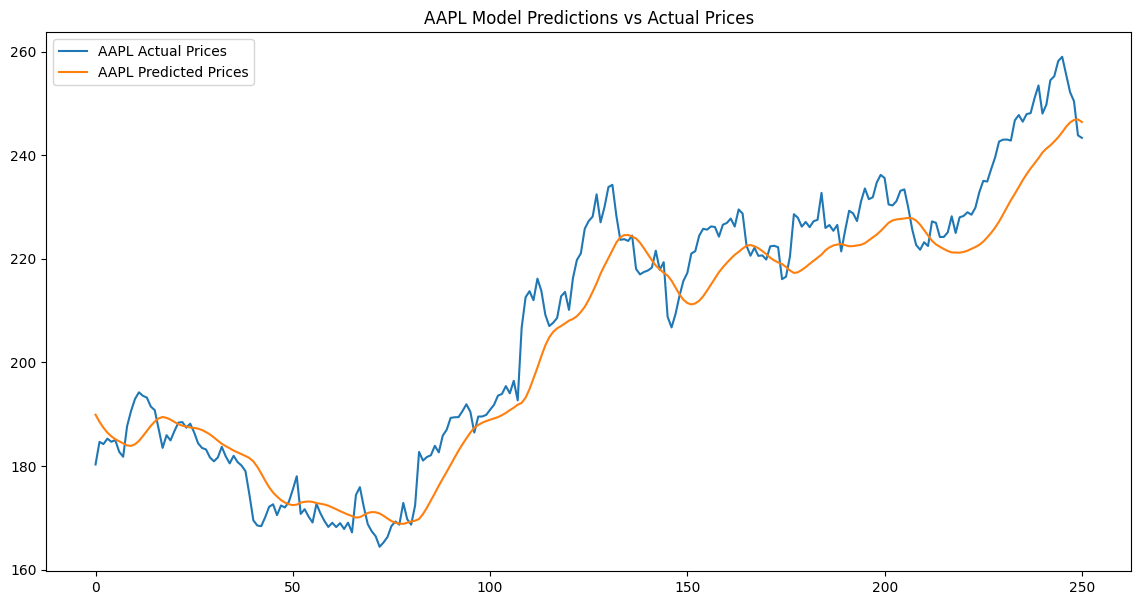

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0406 - val_loss: 0.0109
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0023 - val_loss: 9.8076e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0018 - val_loss: 8.5576e-04
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.001

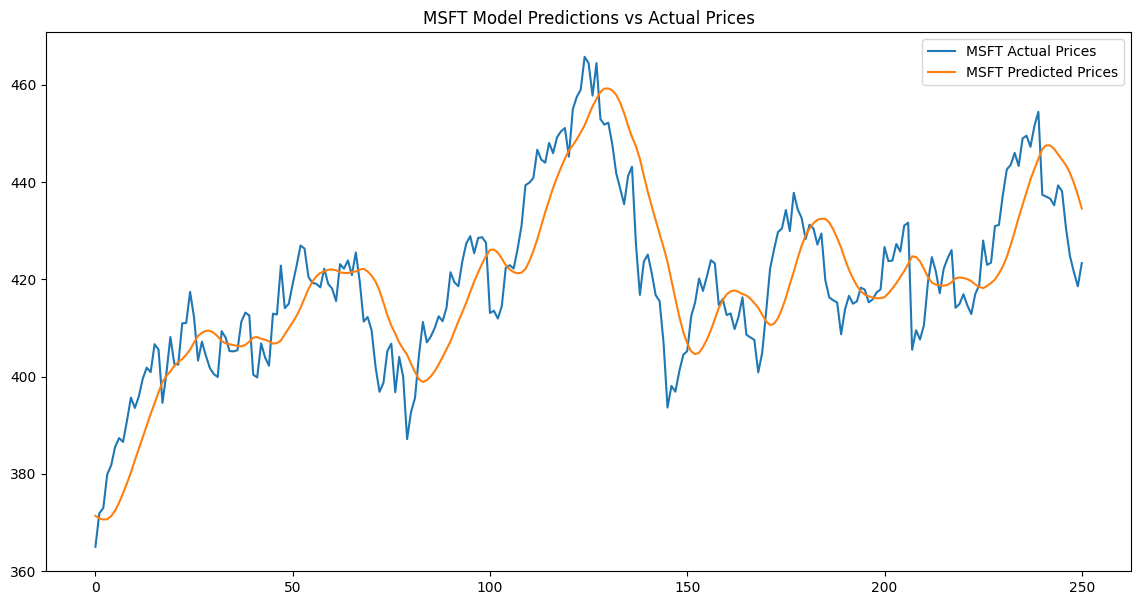

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0781 - val_loss: 0.0034
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0034 - va

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
'root mean squared error' of TSLA = 19.502608726785798
'mean absolute error' of TSLA = 13.314092932469341
MAPE of TSLA = 5.436041777506518


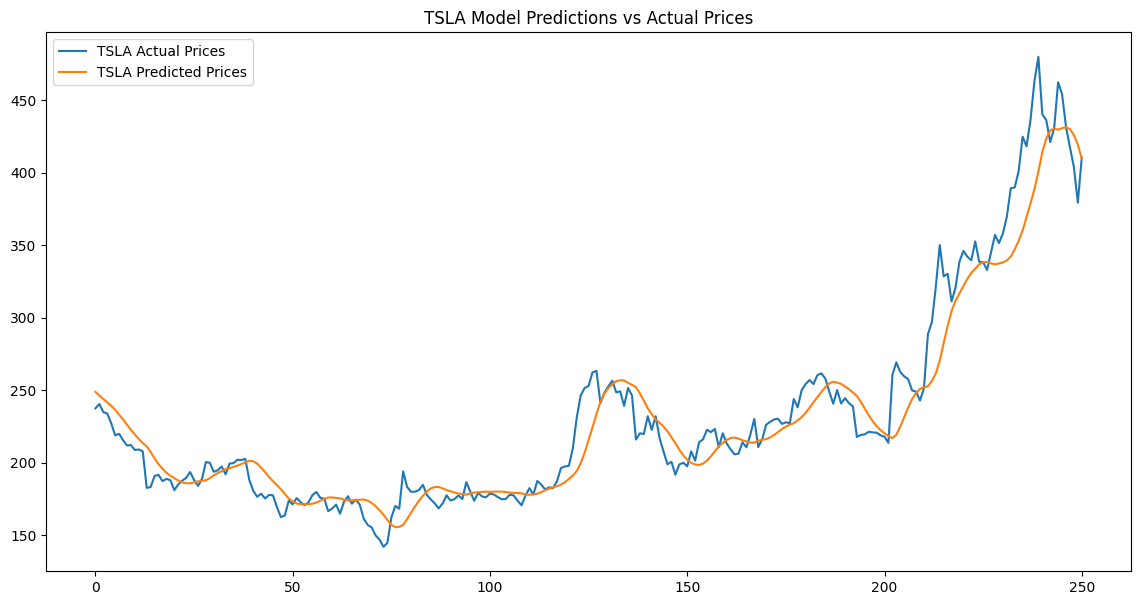

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1127 - val_loss: 0.0043
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0099 - val_loss: 0.0019
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0043 - val_loss: 9.1804e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0043 - val_loss: 8.8821e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0044 - val_loss: 9.6539e-04
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0039 - val_loss: 8.0139e-04
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0038 - val_loss: 8.9784e-04
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
'root mean squared error' of AMZN = 5.800005620345536
'mean absolute error' of AMZN = 4.551275063320935
MAPE of AMZN = 2.439514178826116


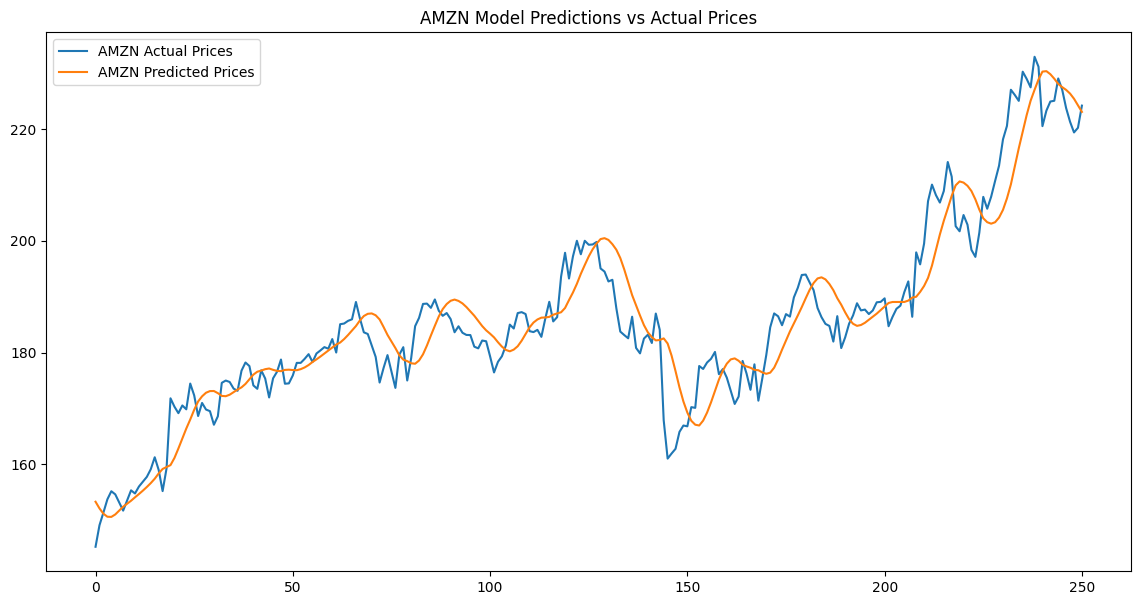

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.5420e-04 - val_loss: 3.2397e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 1.8116e-04 - val_loss: 8.1408e-04
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 1.7949e-04 - val_loss: 3.3428e-04
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 1.4641e-04 - val_loss: 2.5090e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 1.8869e-04 - val_loss: 3.4142e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 1.4335e-04 - val_loss: 2.4402e-04
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.4095e-04 - val_loss: 2.2715e-04
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 1.7015e-04 - val_loss: 2.4666e-04
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 1.4749e-04 - val_loss: 2.8398e-04
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 1.0897e-04 - val_loss: 2.31

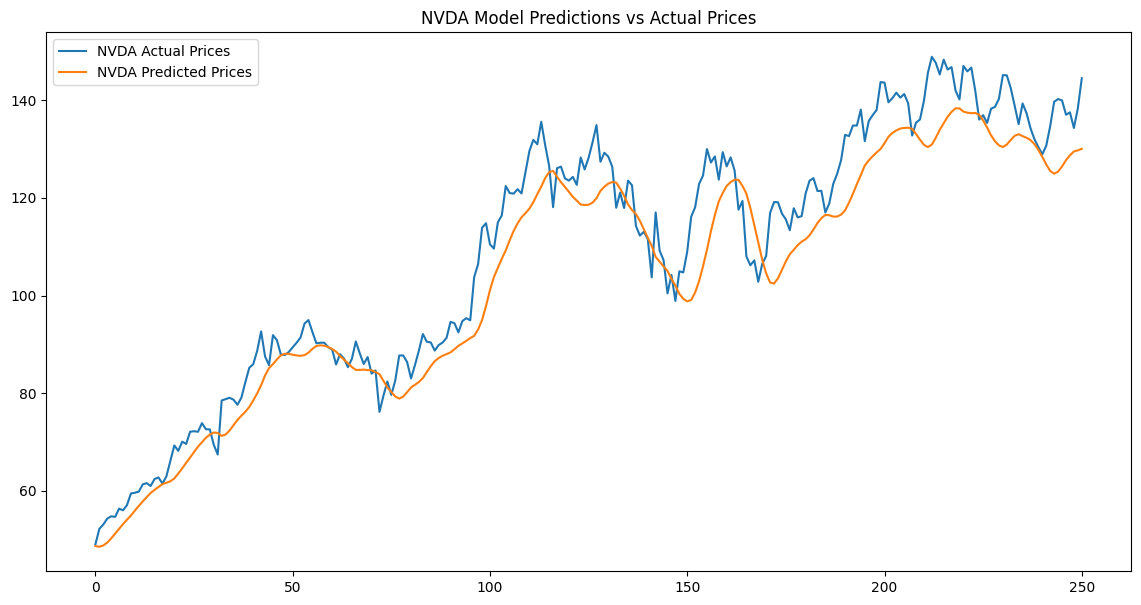

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0297 - val_loss: 0.0012
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0025 - val_loss: 8.8132e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0023 - val_loss: 8.5401e-04
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.002

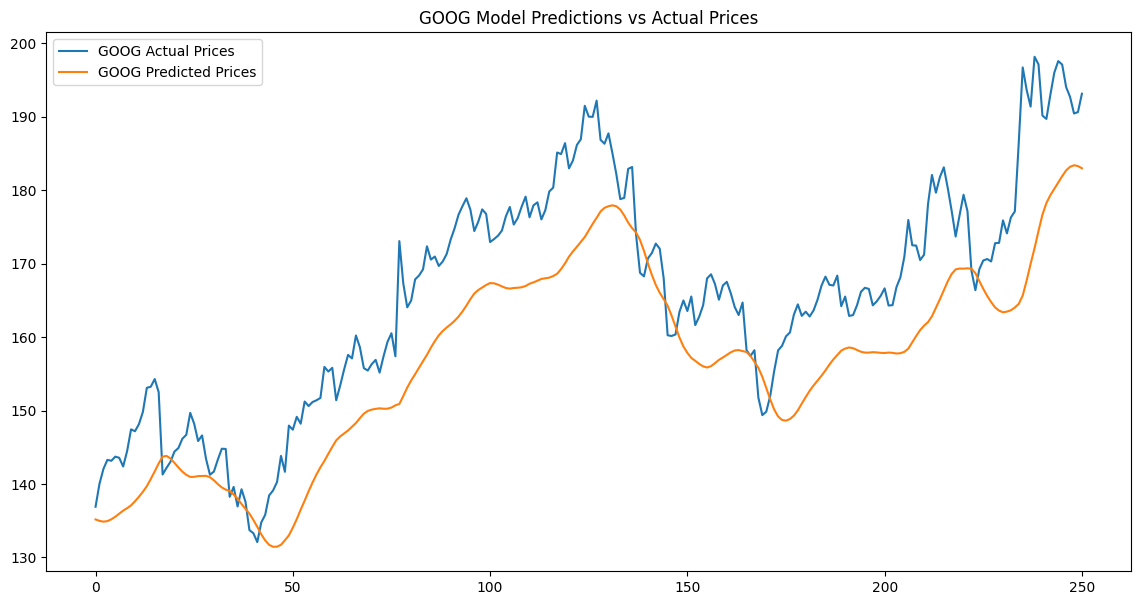

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0561 - val_loss: 8.2178e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0045 - val_loss: 7.3767e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0026 - val_loss: 5.7814e-04
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0027 - val_loss: 7.9133e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0021 - val_loss: 4.5244e-04
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0020 - val_loss: 4.0538e-04
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0025 - val_loss: 4.4353e-04
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0019 - val_loss: 6.1278e-04
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0021 - val_loss: 3.6164e-04
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━

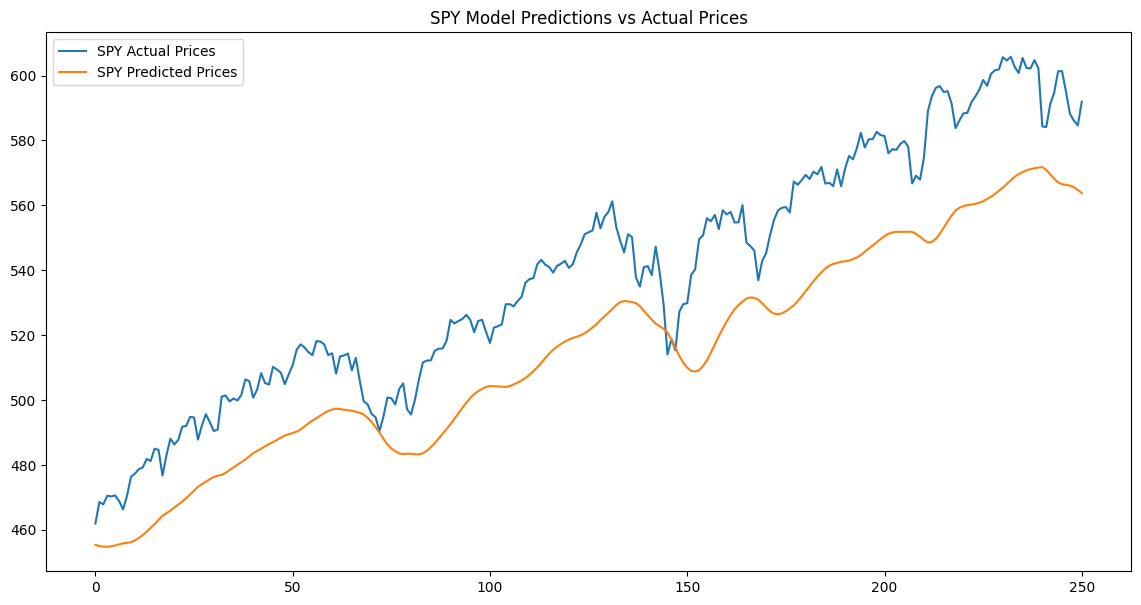

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0513 - val_loss: 0.0154
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0017 - va

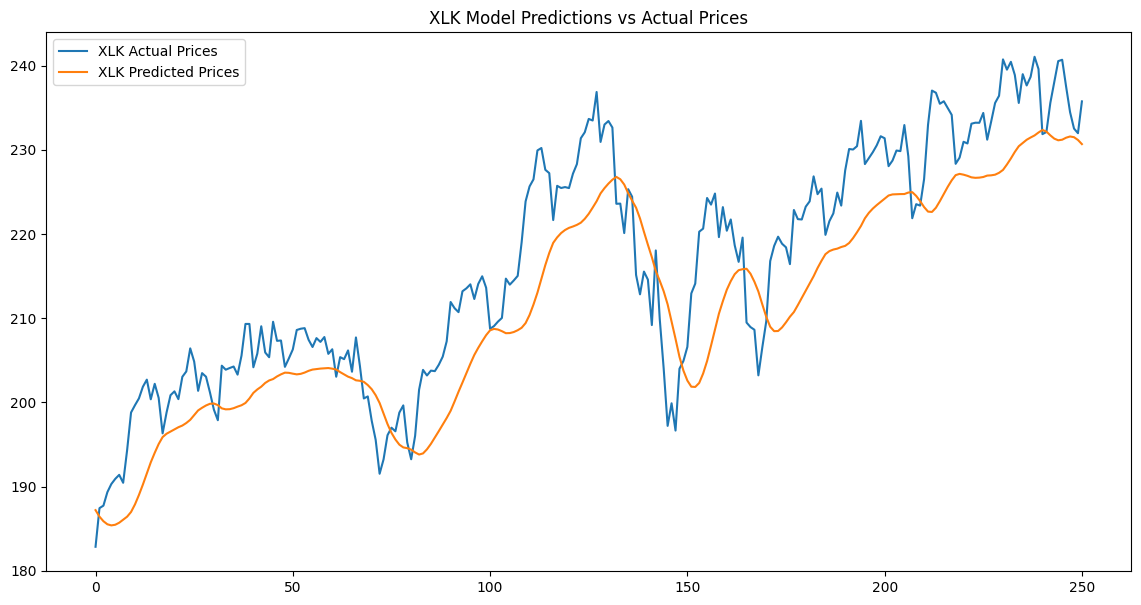

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.0666 - val_loss: 0.0118
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0019 - val_loss: 8.2597e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0020 - val_loss: 4.9575e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0

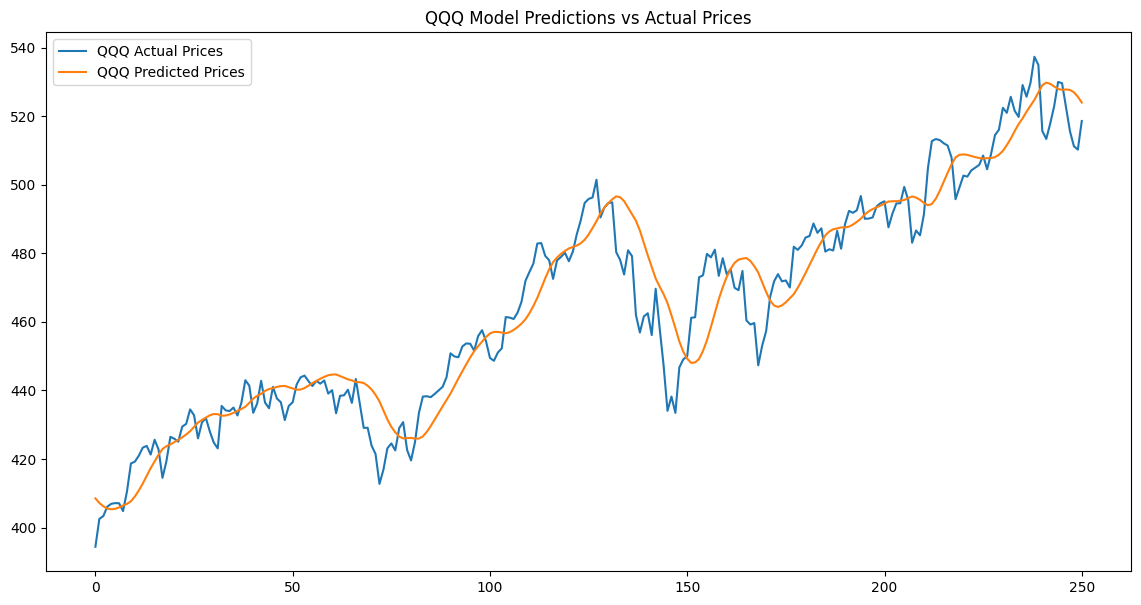

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0299 - val_loss: 0.0047
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0015 - val_loss: 8.0338e-04
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0015 - val_loss: 8.0137e-04
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0015 - val_loss: 7.0443e-04
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0014 - val_loss: 6.9514e-04
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0013 - val_loss: 8.7009e-04
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step 

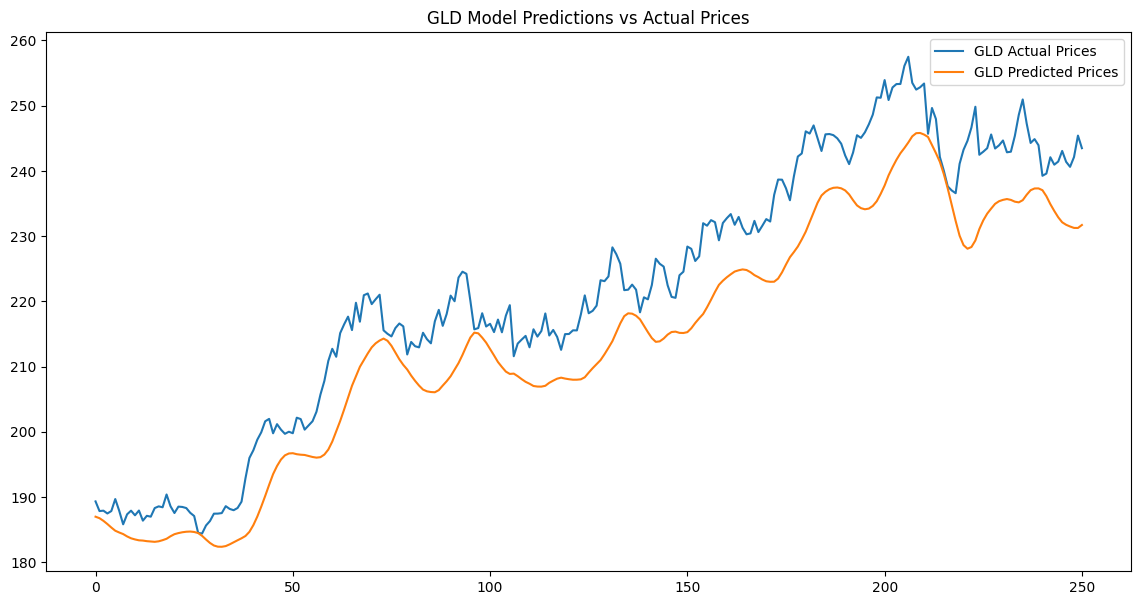

In [22]:
error_table = {}
predicted_returns_data = {}

for i in tickers:
  DATA = stock_data[i]
  DATA = DATA.rename(columns = {i:"Close"})
  rmse, predictions, mae, mape, y_test = Stock_prediction(DATA, i)
  print("'root mean squared error' of {} = ".format(i) + str(rmse))
  print("'mean absolute error' of {} = ".format(i) + str(mae))
  print("MAPE of {} = ".format(i) + str(mape))
  error_table[i] = (rmse, mae, mape)
  predicted_returns_data[i] = predictions
  visualize_predictions(predictions, y_test, i)


 **Model Performance Per Asset:**

In [23]:
error_table = pd.DataFrame(error_table, index=['RMSE', 'MAE', 'MAPE'])
error_table

,AAPL,MSFT,TSLA,AMZN,NVDA,GOOG,SPY,XLK,QQQ,GLD
RMSE,7.334891,10.267127,19.502609,5.800006,7.829931,10.315051,25.698494,7.616985,9.806308,8.824615
MAE,5.889063,8.628977,13.314093,4.551275,6.323050,9.036511,24.070550,6.502147,7.477749,7.886675
MAPE,2.763481,2.057492,5.436042,2.439514,5.661841,5.352220,4.412647,2.981163,1.612322,3.498396


## **Portfolio Optimization**

We begin this section by getting the predicted daily returns from our model and calculating a 6 month moving average for each asset's returns. We then select the top 5 assets that have the highest 6 month moving average to keep in our portfolio:

In [24]:
# Convert predicted prices into daily returns
def compute_daily_returns_from_prices(predicted_returns_data):
    predicted_daily_returns = {}

    for stock, predicted_prices in predicted_returns_data.items():
        # Ensure predictions are a 1D array
        predicted_prices = predicted_prices.flatten()

        # Calculate daily returns
        daily_returns = ((predicted_prices[1:] / predicted_prices[:-1]) - 1) * 100

        # Store in dictionary
        predicted_daily_returns[stock] = daily_returns

    return predicted_daily_returns


# Calculate the 6-month moving average for predicted daily returns
def compute_six_month_moving_avg(predicted_daily_returns):
    six_month_moving_avg_returns = {}

    for stock, daily_returns in predicted_daily_returns.items():
        # Convert daily returns to a pandas Series for rolling calculations
        daily_returns_series = pd.Series(daily_returns)

        # Compute the 6-month moving average (126 trading days)
        moving_avg = daily_returns_series.rolling(window=126).mean()

        # Store the last value of the 6-month moving average
        six_month_moving_avg_returns[stock] = moving_avg.iloc[-1]

    return six_month_moving_avg_returns


# Get top-performing stocks
def get_top_performing_stocks(six_month_moving_avg_returns, top_n=5):
    # Sort stocks by their 6-month moving average returns in descending order
    sorted_stocks = sorted(six_month_moving_avg_returns.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Format the result for display
    print("Top 5 Best-Performing Stocks (6-Month Moving Average of Predicted Daily Returns):")
    for stock, avg_return in sorted_stocks:
        print(f"{stock}: {avg_return:.2f}")

    return sorted_stocks


# Main process
def best_stocks():
    # Step 1: Compute daily returns from predicted prices
    predicted_daily_returns = compute_daily_returns_from_prices(predicted_returns_data)

    # Step 2: Compute the 6-month moving average for daily returns
    six_month_moving_avg_returns = compute_six_month_moving_avg(predicted_daily_returns)

    # Step 3: Get and display the top 5 best-performing stocks
    top_performing_stocks = get_top_performing_stocks(six_month_moving_avg_returns, top_n=5)

    return top_performing_stocks


# Run the process
top_stocks = best_stocks()


Top 5 Best-Performing Stocks (6-Month Moving Average of Predicted Daily Returns):
TSLA: 0.56
AAPL: 0.12
AMZN: 0.11
GLD: 0.09
NVDA: 0.08


**Daily Returns for Best Performing Stocks:**

In [25]:
assets = []
for i in top_stocks:
  assets.append(i[0])

returns = returns[assets].dropna()
returns

Ticker,TSLA,AAPL,AMZN,GLD,NVDA
Date,,,,,
2020-01-07,0.038801,-0.004703,0.002092,0.003935,0.012107
2020-01-08,0.049205,0.016086,-0.007809,-0.007502,0.001876
2020-01-09,-0.021945,0.021241,0.004799,-0.005652,0.010983
2020-01-10,-0.006627,0.002260,-0.009411,0.006026,0.005350
2020-01-13,0.097689,0.021364,0.004323,-0.007419,0.031352
...,...,...,...,...,...
2024-12-27,-0.049479,-0.013242,-0.014534,-0.006871,-0.020868
2024-12-30,-0.033012,-0.013263,-0.010950,-0.003190,0.003503
2024-12-31,-0.032510,-0.007058,-0.008631,0.006234,-0.023275


Below we begin the process of portfolio optimization for our chosen assets.

First we define a function to calculate the metrics we want to be consideren when optimizing out portfolio, namely: **portfolio return, portfolio volatility, and Sharpe Ratio**. **Portfolio Return** is how much the portfolio is expected to make or lose in a given year relative to it's worth. The **Portfolio Volatility** is the annual risk of the portfolio, which is the uncertainty in expected returns. The **Sharpe Ratio** is the return of the portfolio associated with the risk. The goal of our optimization is to maximize the Sharpe Ratio, essentially maximizing the reward to risk ratio of our portfolio. We will show the optimal portfolio below, along with it's asset's weights, sharpe ratio, risk, and expected return:

In [ ]:
num_assets = len(assets)
mean_returns = returns.mean() * 252  # Annualized returns
cov_matrix = returns.cov() * 252  # Annualized covariance matrix

# Step 3: Define portfolio performance metrics
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    weights = np.array(weights)
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio


# Step 4: Define optimization functions
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.04):
    _, _, sharpe_ratio = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    return -sharpe_ratio  # Negative because we want to maximize the Sharpe ratio

def constraint_sum_weights(weights):
    return np.sum(weights) - 1

# Step 5: Optimize portfolio
num_assets = len(assets)
constraints = ({'type': 'eq', 'fun': constraint_sum_weights})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = num_assets * [1. / num_assets]

optimized_result = minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = optimized_result.x

# Step 6: Portfolio Performance and Visualization
optimized_return, optimized_volatility, optimized_sharpe = portfolio_performance(
    optimized_weights, mean_returns, cov_matrix)

print("Optimized Portfolio Weights:")
for ticker, weight in zip(assets, optimized_weights):
    print(f"{ticker}: {weight:.2%}")

print("\nOptimized Portfolio Performance:")
print(f"Expected Annual Return: {optimized_return:.2%}")
print(f"Annual Volatility: {optimized_volatility:.2%}")
print(f"Sharpe Ratio: {optimized_sharpe:.2f}")

And now we can plot the **Efficient Frontier**. The Efficient Frontier shows all portfolios that offer the maximum return for a given level of risk. We will also plot our optimal portfolio along the efficient frontier:

In [26]:
# Plot Efficient Frontier
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def efficient_frontier(mean_returns, cov_matrix, risk_free_rate=0.04):
    frontier_returns = np.linspace(0, max(mean_returns) + 0.04, 100)
    frontier_volatilities = []

    for target_return in frontier_returns:
        constraints = [{'type': 'eq', 'fun': constraint_sum_weights},
                       {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}]
        result = minimize(portfolio_volatility, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            frontier_volatilities.append(result.fun)
        else:
            frontier_volatilities.append(np.nan)

    return frontier_returns, frontier_volatilities

frontier_returns, frontier_volatilities = efficient_frontier(mean_returns, cov_matrix)

fig = go.Figure()

# Efficient Frontier plot
fig.add_trace(go.Scatter(x=frontier_volatilities, y=frontier_returns, mode='lines',
                         name='Efficient Frontier', line=dict(color='blue', width=3)))

# Step 3: Plot Optimal Portfolio (Maximum Sharpe Ratio Portfolio)
optimized_result = minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = optimized_result.x
optimized_return, optimized_volatility, optimized_sharpe = portfolio_performance(
    optimized_weights, mean_returns, cov_matrix)

# Plot Optimal Portfolio (Maximum Sharpe Ratio Portfolio)
fig.add_trace(go.Scatter(x=[optimized_volatility], y=[optimized_return], mode='markers',
                         name='Optimal Portfolio', marker=dict(color='red', size=10, symbol='star')))

# Step 4: Customize Layout for Interactivity
fig.update_layout(
    title='Efficient Frontier with Optimal Portfolio',
    xaxis_title='Portfolio Volatility %(Std. Dev.)',
    yaxis_title='Portfolio Return %',
    showlegend=True,
    template='plotly_dark',
    hovermode="closest",
    width=800,
    height=600
)

# Show the plot interactively
fig.show()

Optimized Portfolio Weights:
TSLA: 16.51%
AAPL: 0.00%
AMZN: 0.00%
GLD: 39.24%
NVDA: 44.25%

Optimized Portfolio Performance:
Expected Annual Return: 51.57%
Annual Volatility: 32.02%
Sharpe Ratio: 1.49


## **Conclusion**

This project successfully demonstrated the integration of Long Short-Term Memory (LSTM) networks with Mean-Variance Optimization (MVO) for portfolio optimization. By leveraging LSTM models to predict asset returns and using moving averages to identify top-performing stocks, the optimized portfolio achieved a **Sharpe Ratio** of **1.49**, an expected **annual return** of **51.57%**, and **annual volatility** of **32.02%**.

The project emphasized the potential of deep learning models in financial decision-making, showcasing the ability of LSTMs to capture temporal patterns in asset prices. The optimization process effectively concentrated weights in high-performing assets such as GLD (39.24%) and NVDA (44.25%), reflecting their superior predicted returns and risk-adjusted performance.

**Future Directions**

To further enhance this approach, several avenues can be explored:

- Experimenting with advanced LSTM architectures (e.g., bidirectional LSTMs or attention mechanisms).

- Incorporating larger and more diverse datasets, including additional stocks and longer historical data.

- Implementing ensemble learning methods to improve prediction robustness.

- Exploring reinforcement learning frameworks for dynamic portfolio rebalancing.